In [1]:
from typing import (
    Tuple,
    List,
    Dict,
    Any,
    Sequence,
    Union,
    Optional,
)

import sys
import time
import json
import re
from pathlib import Path
from enum import Enum
import shutil

import pandas as pd
import polars as pl
import polars.selectors as cs

# 상대 경로 사용
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'

# 로컬 모듈
# 맨 앞에 추가
if str(PROJECT_ROOT) in sys.path:
    sys.path.remove(str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))
from src.preprocess.preprocess import overview_col, analyze_null_values, eda_proportion

# 이제 import
from src.loading import DataLoader
from src.utils import increment_path

output_file = DATA_DIR / 'temp' / 'maude_clustered.parquet'
loader = DataLoader(
    # output_file= DATA_DIR / 'silver' / 'maude50.parquet',
    output_file= output_file,
)

adapter = 'polars'
polars_kwargs = {
    'use_statistics': True,
    'parallel': 'auto',
    'low_memory': False,
    'rechunk': False,
    'cache': True,
}
maude_lf = loader.load(adapter=adapter, **polars_kwargs)
maude_lf


📖 /home/dataiku/eric/Sparta/Project3/data/temp/maude_clustered.parquet 로딩 중... (adapter=polars)


In [2]:
from cuml import UMAP
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

# 1. GPU 메모리로 직접 전송
embedding_df: pl.DataFrame = maude_lf.select(pl.col('embeddings')).collect()
cluster_df: pl.DataFrame = maude_lf.select(pl.col('cluster')).collect()

In [3]:
embeddings_array = np.vstack(embedding_df['embeddings'].to_list())
clusters = cluster_df['cluster'].to_numpy()

# 2. CuPy 배열로 변환 (GPU 메모리 활용)
embeddings_gpu = cp.asarray(embeddings_array, dtype=cp.float32)

In [ ]:
import joblib

umap_model = UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=15,
    metric='cosine',
    random_state=42,
    verbose=True
)
X = umap_model.fit_transform(embeddings_gpu)
X = cp.asarray(X, dtype=cp.float32)

[2025-12-25 15:38:51.778] [CUML] [debug] Computing KNN Graph
[2025-12-25 15:39:11.796] [CUML] [debug] Computing fuzzy simplicial set


In [46]:
import joblib

model_path = PROJECT_ROOT / 'models' / 'umap_model.joblib'
joblib.dump(umap_model, model_path)

['/home/dataiku/eric/Sparta/Project3/models/umap_model.joblib']

In [43]:
# maude_lf에 PC1, PC2 컬럼 추가 (LazyFrame 유지)
maude_lf = maude_lf.with_columns([
    pl.Series('UMAP', X.tolist()).alias('UMAP'),
])
maude_lf.collect_schema().names()

['mdr_report_key',
 'adverse_event_flag',
 'product_problem_flag',
 'date_occurred',
 'date_received',
 'date_manufactured',
 'event_type',
 'previous_use_flag',
 'single_use_flag',
 'reprocessed_and_reused_flag',
 'product_problems',
 'manufacturer_name',
 'brand_name',
 'model_number',
 'udi_di',
 'product_code',
 'operator',
 'product_name',
 'patient_age',
 'mdr_text',
 'outcome_L',
 'outcome_H',
 'outcome_S',
 'outcome_C',
 'outcome_R',
 'outcome_D',
 'outcome_O',
 'patient_harm',
 'problem_components',
 'defect_confirmed',
 'defect_type',
 'mdr_sntc',
 'embeddings',
 'cluster',
 'UMAP']

In [45]:
output_path = DATA_DIR / 'gold' / 'maude_umap.parquet'
maude_lf.sink_parquet(
    output_path,
    compression='zstd',
    compression_level=3,
    maintain_order=True,
    statistics=True,
    mkdir=True,
)

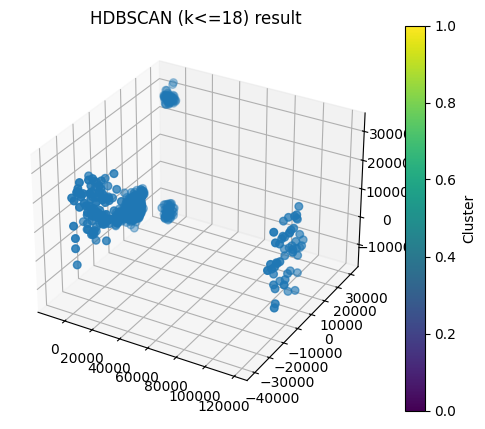

In [23]:
import cupy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

X_np = cp.asnumpy(X) if hasattr(X, "get") else X
clusters_np = cp.asnumpy(clusters) if hasattr(clusters, "get") else clusters

Z = PCA(n_components=3).fit_transform(X_np)

df_temp = pd.DataFrame({
    "PC1": Z[:,0],
    "PC2": Z[:,1],
    "PC3": Z[:,2],
    "Cluster": clusters_np
})

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_temp["PC1"], df_temp["PC2"], df_temp["PC3"], s=30)

plt.colorbar(sc, ax=ax, label='Cluster')
plt.title("HDBSCAN (k<=18) result")
plt.show()

In [ ]:
import plotly.express as px

# 기본 사용법
fig = px.scatter_3d(
    df_temp, 
    x='PC1', 
    y='PC2', 
    z='PC3',
    color='Cluster',
    color_discrete_sequence=['red', 'blue', 'green'],
    symbol='Cluster',
)
fig.update_traces(marker_size = 5)
fig.show(renderer='notebook')


# # 추가 옵션들
# fig = px.scatter_3d(df_temp, 
#                     x='sepal_length', 
#                     y='sepal_width', 
#                     z='petal_width',
#                     color='species',  # 카테고리형
#                     color_discrete_sequence=['red', 'blue', 'green'],  # 색상 지정
#                     symbol='species',  # 마커 모양도 다르게
#                     size='petal_length',  # 크기도 다르게
#                     hover_data=['species'])  # 호버 정보

In [ ]:
# # 클러스터 분포 확인
# print("클러스터 분포:")
# unique, counts = np.unique(clusters, return_counts=True)
# for u, c in zip(unique, counts):
#     print(f"  Cluster {u}: {c:,}개 ({c/len(clusters)*100:.2f}%)")
    
# # 임베딩 통계 확인
# print(f"\n임베딩 shape: {embeddings_array.shape}")
# print(f"UMAP 결과 shape: {X_np.shape}")

# # 15차원 UMAP 결과의 분산 확인
# print(f"\nUMAP 15차원 결과의 차원별 분산:")
# for i in range(min(5, X_np.shape[1])):
#     print(f"  Dim {i}: {np.var(X_np[:,i]):.4f}")

In [ ]:
# # HDBSCAN을 15차원 UMAP 결과에 다시 적용 (파라미터 조정)
# from cuml.cluster import HDBSCAN

# # 여러 파라미터로 실험
# params_list = [
#     {'min_cluster_size': 50, 'min_samples': 10, 'cluster_selection_epsilon': 0.0},
#     {'min_cluster_size': 30, 'min_samples': 5, 'cluster_selection_epsilon': 0.0},
#     {'min_cluster_size': 100, 'min_samples': 20, 'cluster_selection_epsilon': 0.5},
# ]

# for i, params in enumerate(params_list):
#     print(f"\n=== 실험 {i+1}: {params} ===")
    
#     clusterer = HDBSCAN(**params, metric='euclidean', verbose=False)
#     new_clusters = clusterer.fit_predict(X)
#     new_clusters_np = cp.asnumpy(new_clusters)
    
#     # 결과 확인
#     unique, counts = np.unique(new_clusters_np, return_counts=True)
#     print(f"발견된 클러스터 수: {len([u for u in unique if u >= 0])}개")
#     for u, c in zip(unique, counts):
#         print(f"  Cluster {u}: {c:,}개 ({c/len(new_clusters_np)*100:.2f}%)")

In [ ]:
# # maude_lf에 PC1, PC2 컬럼 추가 (LazyFrame 유지)
# maude_lf = maude_lf.with_columns([
#     pl.lit(Z[:,0]).alias('PC1'),
#     pl.lit(Z[:,1]).alias('PC2')
# ])
# maude_lf.collect_schema().names()

In [ ]:
# output_path = DATA_DIR / 'gold' / 'maude_clustered_viz.parquet'
# maude_lf.sink_parquet(
#     output_path,
#     compression='zstd',
#     compression_level=3,
#     maintain_order=True,
#     statistics=True,
#     mkdir=True,
# )

In [ ]:
# # 3. UMAP 파라미터 최적화
# umap_2d = UMAP(n_components=2, random_state=42)

# # 4. GPU에서 변환
# embedding_2d_gpu = umap_2d.fit_transform(embeddings_gpu)

# # 5. 시각화를 위해
# embedding_2d = cp.asnumpy(embedding_2d_gpu)

# plt.figure(figsize=(12, 8))
# scatter = plt.scatter(
#     embedding_2d[:, 0], 
#     embedding_2d[:, 1], 
#     c=clusters, 
#     cmap='tab20', 
#     alpha=0.6,
#     s=5
# )
# # plt.colorbar(scatter)
# plt.title('Cluster')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.tight_layout()
# plt.show()

# # 메모리 정리
# del embeddings_gpu, embedding_2d_gpu